In [1]:
import pandas as pd

fce = pd.read_csv("test_data/fce-1828.csv", sep=",")
CoNLL = pd.read_csv("test_data/CoNLL-1195.csv", sep=",")
jfleg = pd.read_csv("test_data/jfleg-713.csv", sep=",")
wi = pd.read_csv("test_data/wi+lochness-2856.csv", sep=",")
print(len(fce))
print(len(CoNLL))
print(len(jfleg))
print(len(wi))

1828
1195
713
2856


In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch


In [6]:

from nltk.translate.gleu_score import sentence_gleu
from nltk.tokenize import word_tokenize
import statistics
from tqdm import tqdm
import matplotlib.pyplot as plt

class Evaluation:
    def __init__(self, model_path = None, included_prefix = False) -> None:
        if not model_path:
            raise Exception("Model path must not be incluced")
        self.model_path = model_path
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model.eval()
        self.included_prefix = included_prefix
    def correct_sentence(self, sentence, model, tokenizer, include_prefix = False):
        if not include_prefix:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {key: value.to(model.device) for key, value in inputs.items()}
            outputs = model.generate(**inputs, max_length=128, num_beams=5)
            return tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            # Add prefix to input text
            PREFIX = "grammar error correction: "
            prefixed_text = PREFIX + sentence
            
            # Tokenize with adjusted max_length
            prefix_token_count = len(tokenizer.encode(PREFIX)) - 2
            inputs = tokenizer(prefixed_text, return_tensors="pt", padding=True, 
                            truncation=True, max_length=128 + prefix_token_count)
            
            # Move to same device as model
            input_ids = inputs.input_ids.to(model.device)
            attention_mask = inputs.attention_mask.to(model.device)
            
            # Generate output
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=128,
                num_beams=4,
                early_stopping=True,
                length_penalty=2.0,
                no_repeat_ngram_size=3
            )
            
            # Decode output
            corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            return corrected_text

    def calculate_metrics(self, incorrect, ground_truth):
        gleu_scores = []
        f0_5_scores = []
        predictions = []

        for i in tqdm(range(len(incorrect))):
            pred = self.correct_sentence(incorrect[i], self.model, self.tokenizer, self.included_prefix)
            predictions.append(pred)

            ref_tokens = word_tokenize(str(ground_truth[i]).lower(), language="english", preserve_line=True)
            pred_tokens = word_tokenize(str(pred).lower(), language="english", preserve_line=True)

            # GLEU score
            gleu = sentence_gleu([ref_tokens], pred_tokens)
            gleu_scores.append(gleu)

            # F0.5 calculation (token-level)
            TP = sum(p == r for p, r in zip(pred_tokens, ref_tokens))
            FP = max(0, len(pred_tokens) - TP)
            FN = max(0, len(ref_tokens) - TP)
        
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
            beta_squared = 0.5 ** 2
            f0_5 = (
                (1 + beta_squared) * precision * recall / (beta_squared * precision + recall)
                if (precision + recall) > 0
                else 0.0
            )
            f0_5_scores.append(f0_5)
        print("Mean GLEU:", statistics.mean(gleu_scores))
        print("Mean F0.5:", statistics.mean(f0_5_scores))
        # Plotting
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(gleu_scores, bins=30, color='skyblue', edgecolor='black')
        plt.title("Distribution of GLEU Scores")
        plt.xlabel("GLEU Score")
        plt.ylabel("Frequency")

        plt.subplot(1, 2, 2)
        plt.hist(f0_5_scores, bins=30, color='salmon', edgecolor='black')
        plt.title("Distribution of F0.5 Scores")
        plt.xlabel("F0.5 Score")
        plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()
    def evaluate_test(self):
        print(f"Evaluation result for {self.model_path}")
        # CoNLL
        incorrect = CoNLL["Incorrect"].tolist()
        ground_truth = CoNLL["Corrected"].tolist()
        print("--CoNLL--")
        self.calculate_metrics(incorrect, ground_truth)

        #FCE
        incorrect = fce["Incorrect"].tolist()
        ground_truth = fce["Corrected"].tolist()
        print("--FCE--")
        self.calculate_metrics(incorrect, ground_truth)

        #JFLEG
        incorrect = jfleg["Incorrect"].tolist()
        ground_truth = jfleg["Corrected"].tolist()
        print("--JFLEG--")
        self.calculate_metrics(incorrect, ground_truth)

        #WI+LOCHNESS
        incorrect = wi["Incorrect"].tolist()
        ground_truth = wi["Corrected"].tolist()
        print("--WI+LOCHNESS--")
        self.calculate_metrics(incorrect, ground_truth)

In [4]:
prefix_model_paths = ["./bart_base_1%MT_2stage_final", "./bart_base_10%MT_2stage_final", "./bart_base_prefix" ]

no_prefix_model_paths = ["./bart_base_no_prefix", "./bart_large_no_prefix_61GLEU"]

Evaluation result for ./bart_base_1%MT_2stage_final
--CoNLL--


100%|██████████| 1195/1195 [03:49<00:00,  5.22it/s]

Mean GLEU: 0.6203435820812904
Mean F0.5: 0.4531308609409177


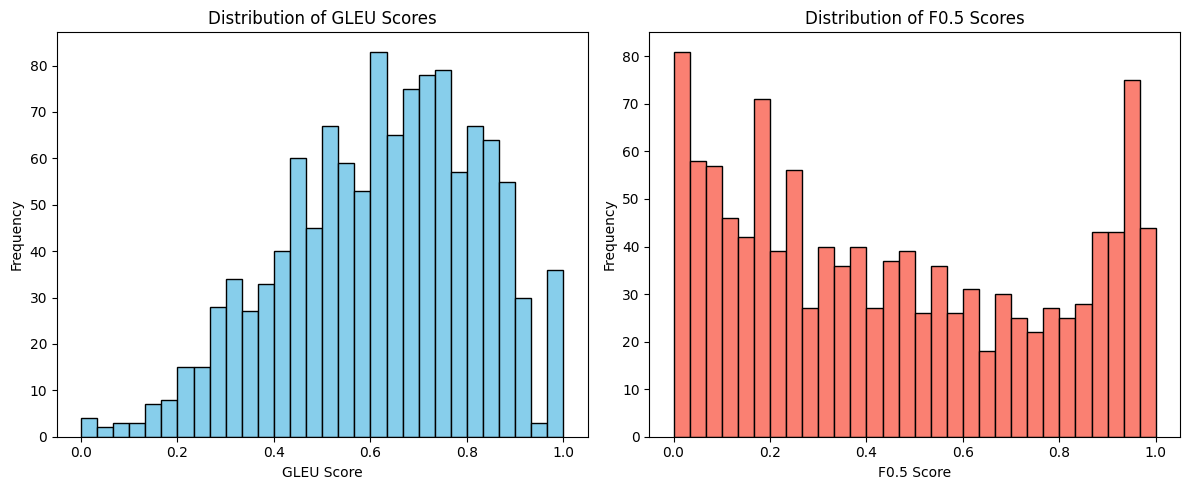

--FCE--


100%|██████████| 1828/1828 [04:37<00:00,  6.58it/s]

Mean GLEU: 0.7100389215943056
Mean F0.5: 0.5985806741664513


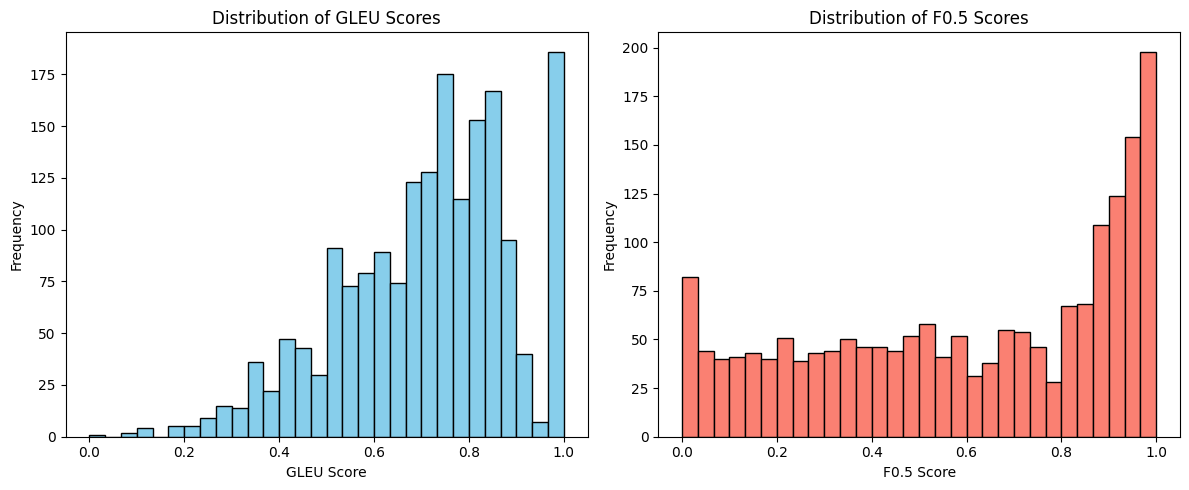

--JFLEG--


100%|██████████| 713/713 [01:54<00:00,  6.24it/s]


Mean GLEU: 0.4188494045794273
Mean F0.5: 0.2996727810847809


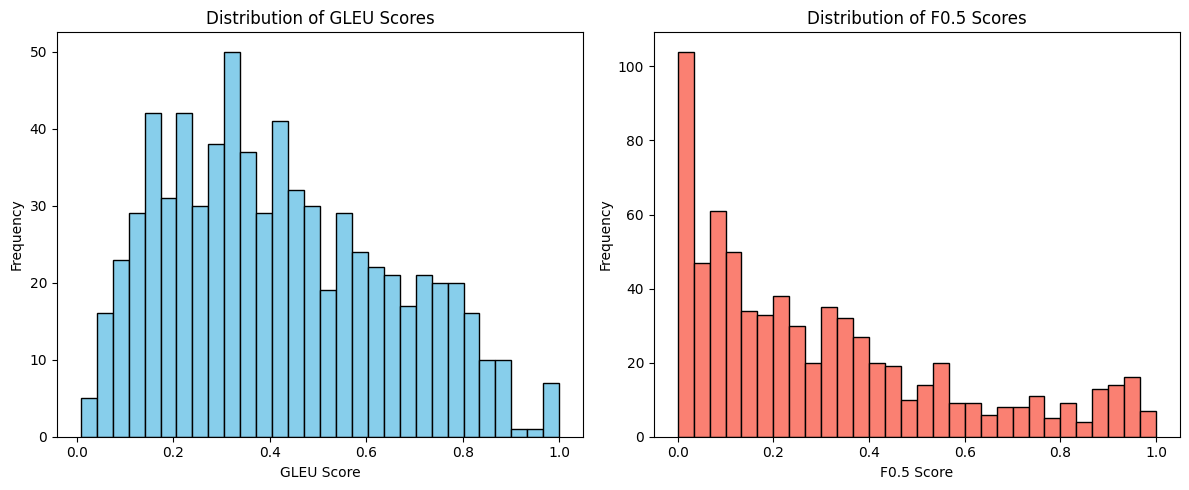

--WI+LOCHNESS--


100%|██████████| 2856/2856 [09:41<00:00,  4.91it/s]


Mean GLEU: 0.7482666982626144
Mean F0.5: 0.5673966298218474


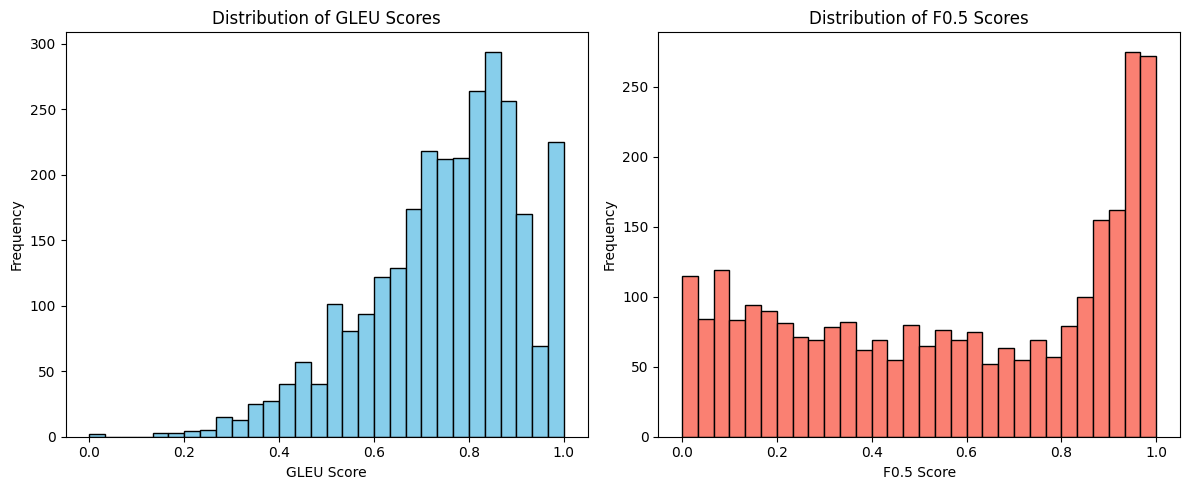

Evaluation result for ./bart_base_10%MT_2stage_final
--CoNLL--


100%|██████████| 1195/1195 [03:44<00:00,  5.33it/s]

Mean GLEU: 0.6243391319927598
Mean F0.5: 0.4567508905487724


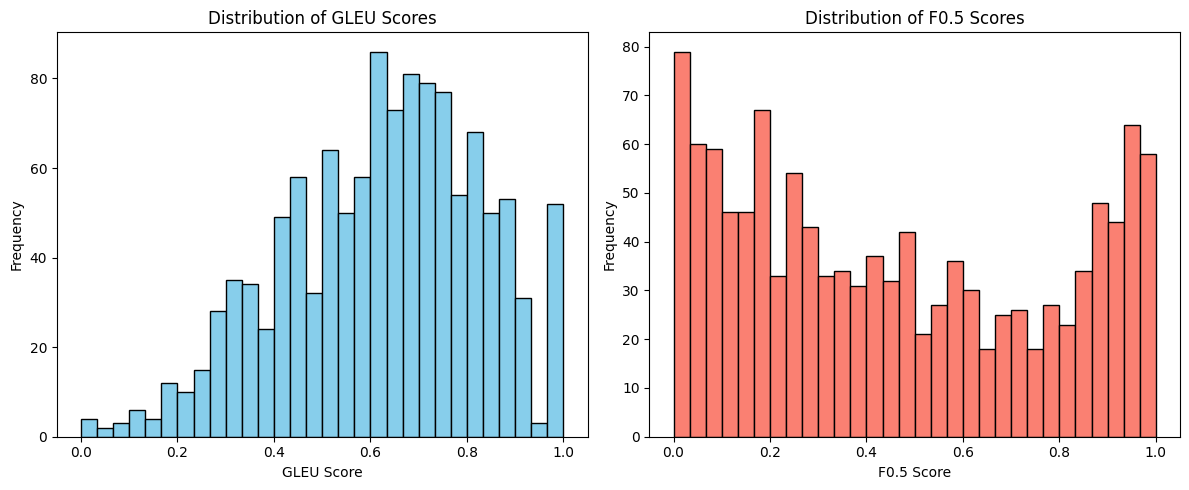

--FCE--


100%|██████████| 1828/1828 [06:14<00:00,  4.88it/s]


Mean GLEU: 0.7220576084150355
Mean F0.5: 0.607734797062327


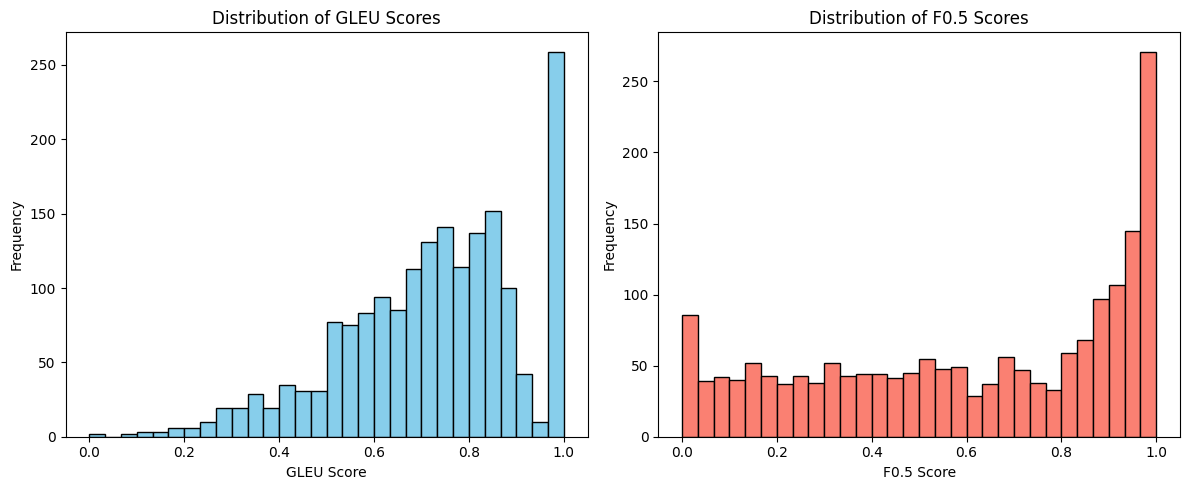

--JFLEG--


100%|██████████| 713/713 [01:52<00:00,  6.35it/s]


Mean GLEU: 0.4338947933521573
Mean F0.5: 0.30805252042507836


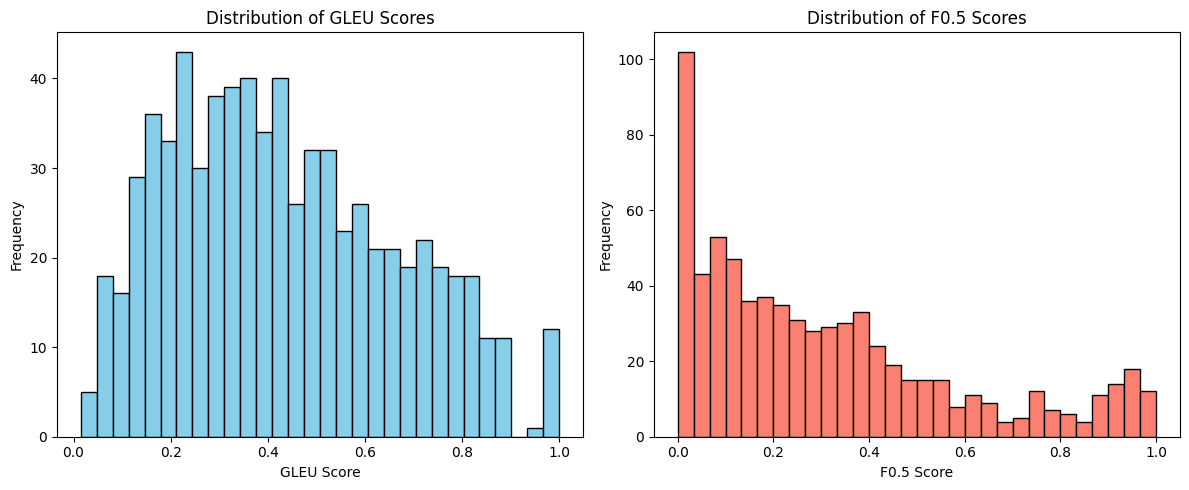

--WI+LOCHNESS--


100%|██████████| 2856/2856 [09:48<00:00,  4.85it/s]


Mean GLEU: 0.759091076277626
Mean F0.5: 0.5860604059659038


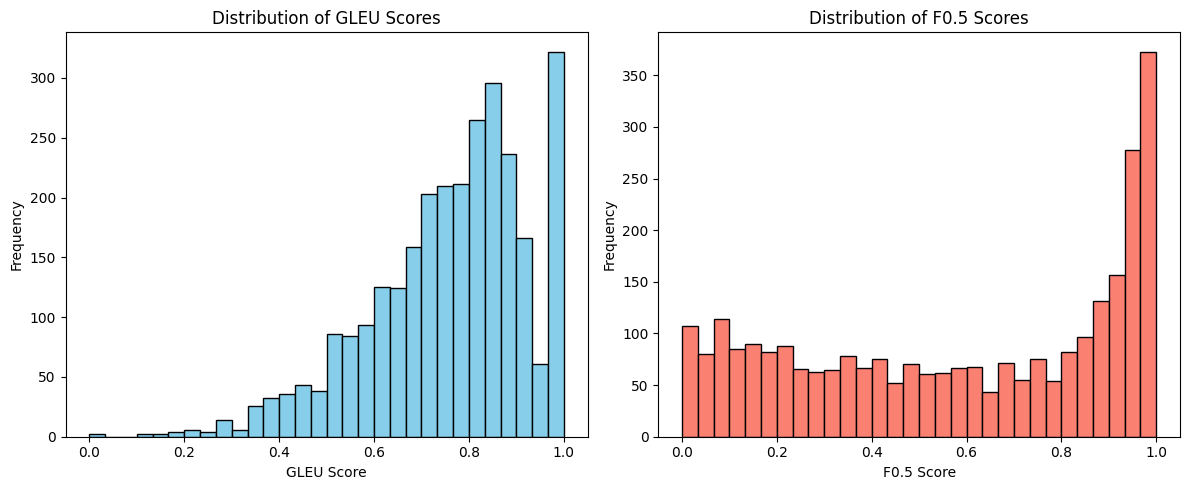

Evaluation result for ./bart_base_prefix
--CoNLL--


100%|██████████| 1195/1195 [03:28<00:00,  5.73it/s]

Mean GLEU: 0.6283120117275809
Mean F0.5: 0.4587592532786922


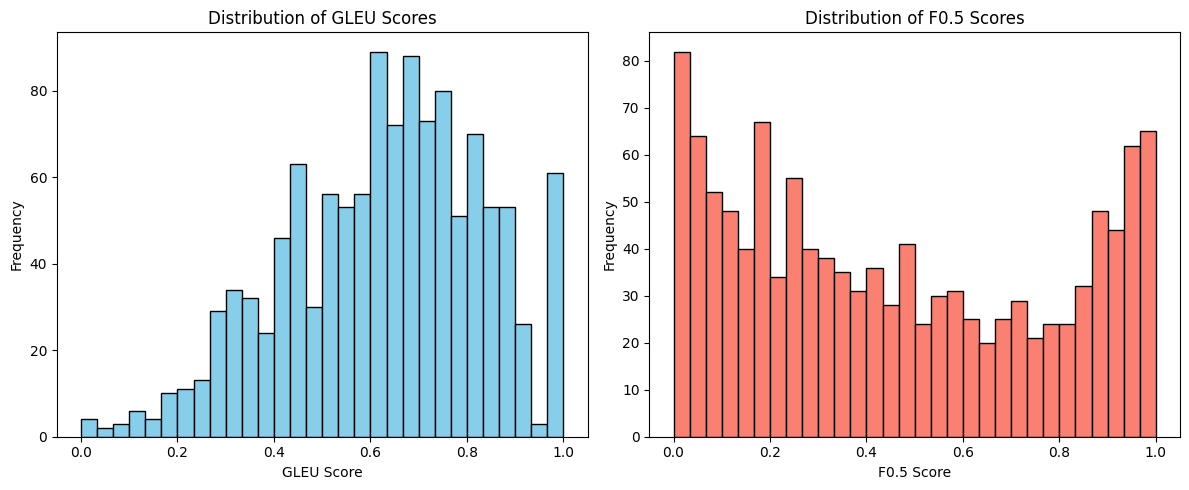

--FCE--


100%|██████████| 1828/1828 [06:23<00:00,  4.77it/s]

Mean GLEU: 0.7205080870148489
Mean F0.5: 0.6015598018838794


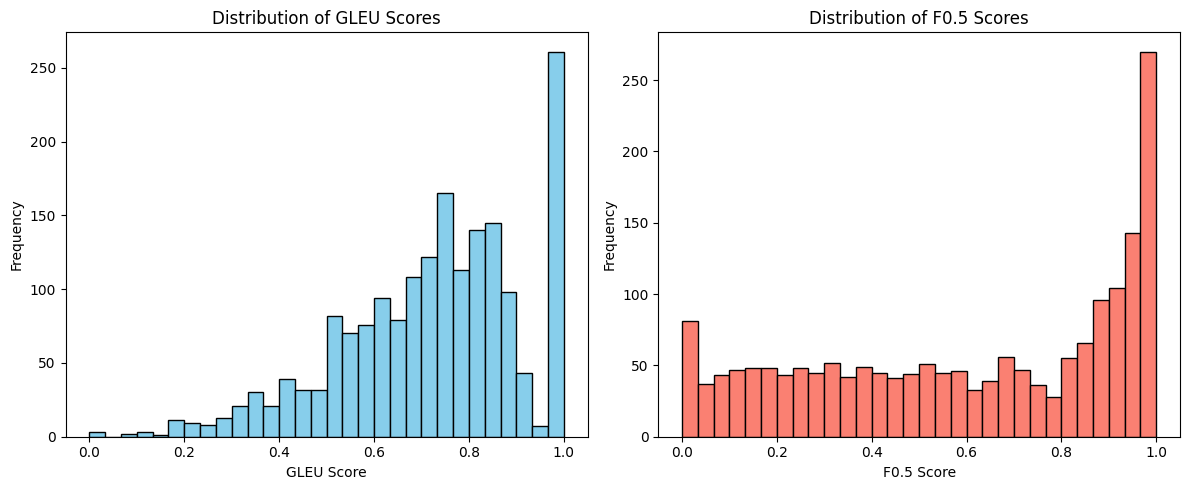

--JFLEG--


100%|██████████| 713/713 [02:11<00:00,  5.42it/s]


Mean GLEU: 0.42996993188719906
Mean F0.5: 0.30712066629378865


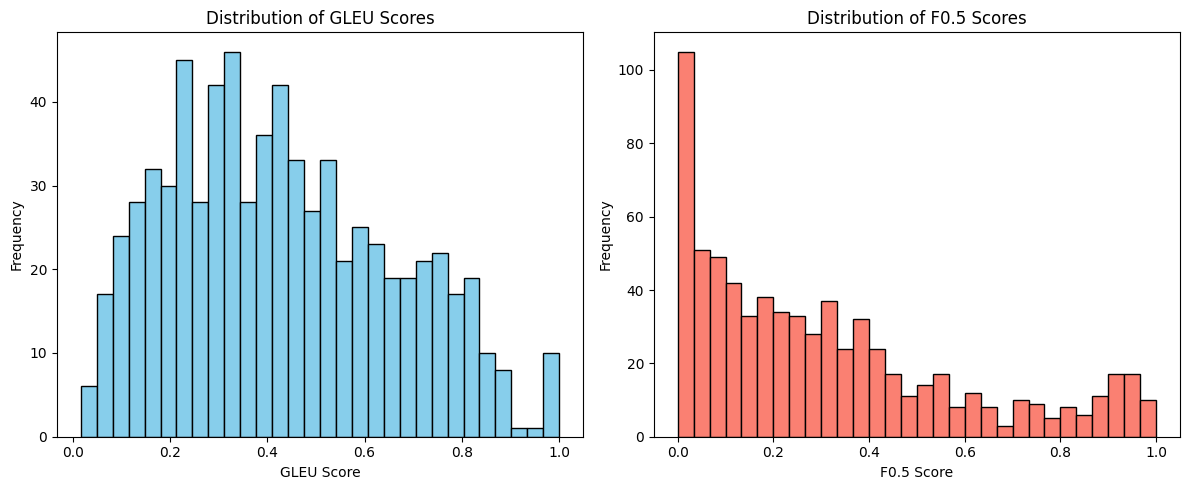

--WI+LOCHNESS--


100%|██████████| 2856/2856 [14:39<00:00,  3.25it/s]


Mean GLEU: 0.7596817888332348
Mean F0.5: 0.5843866558399122


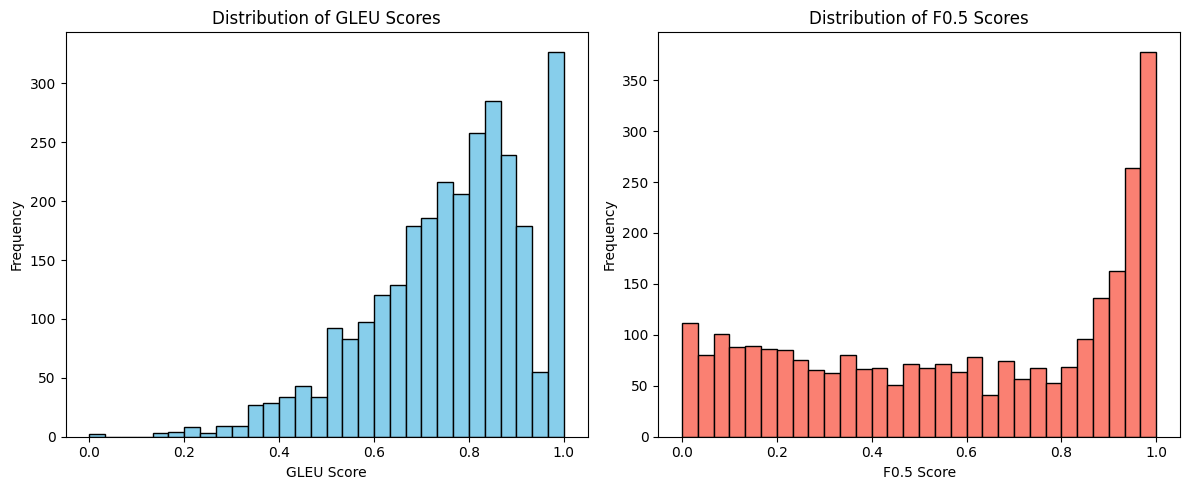

In [7]:
for path in prefix_model_paths:
    evaluation_engine = Evaluation(path, True)
    evaluation_engine.evaluate_test()

Evaluation result for ./bart_base_no_prefix
--CoNLL--


100%|██████████| 1195/1195 [03:47<00:00,  5.25it/s]

Mean GLEU: 0.628370284764206
Mean F0.5: 0.46321846245791104


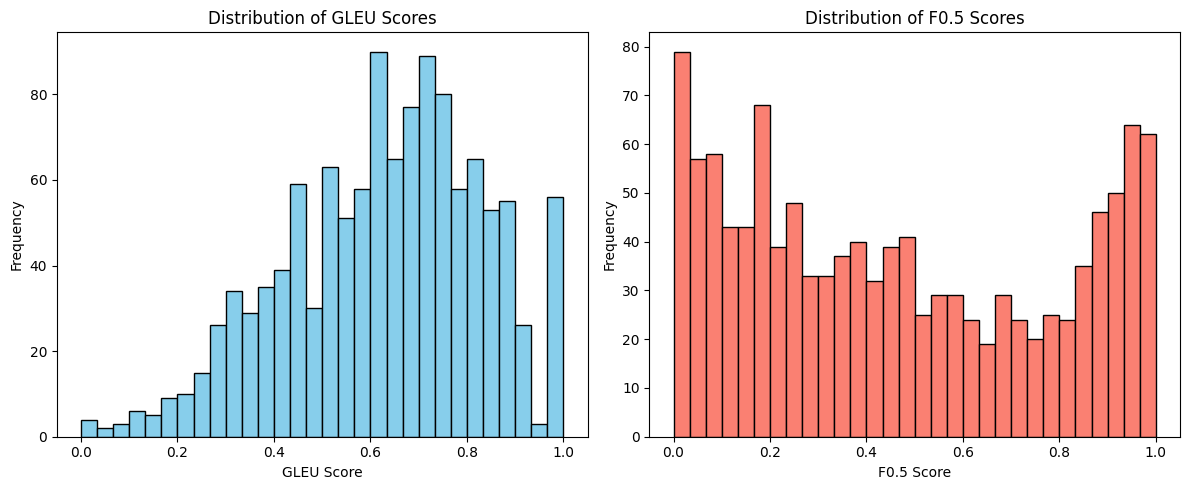

--FCE--


100%|██████████| 1828/1828 [05:45<00:00,  5.29it/s]

Mean GLEU: 0.7266476367383202
Mean F0.5: 0.6139232360354109


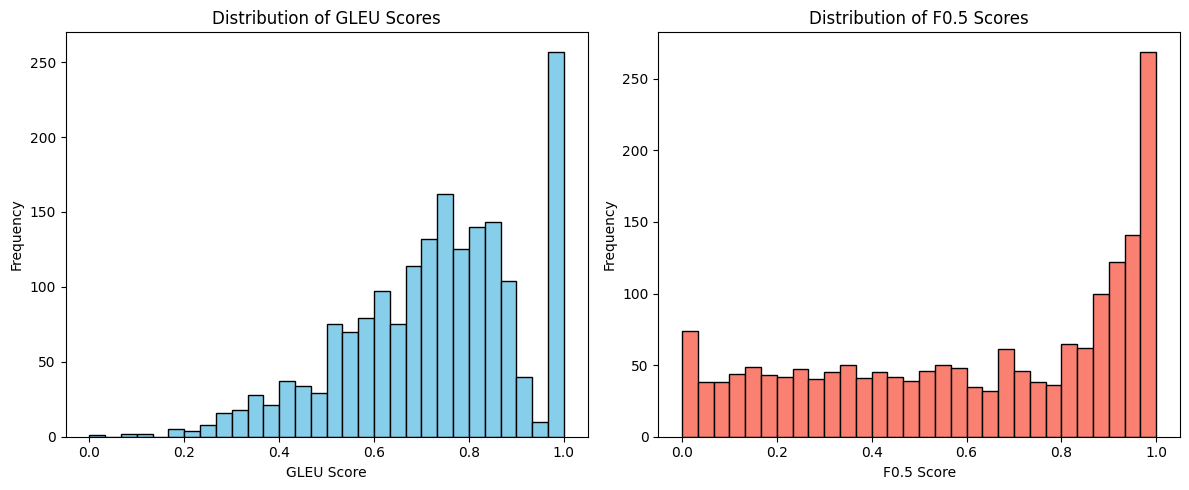

--JFLEG--


100%|██████████| 713/713 [01:56<00:00,  6.13it/s]


Mean GLEU: 0.4280637303527844
Mean F0.5: 0.3075692278905824


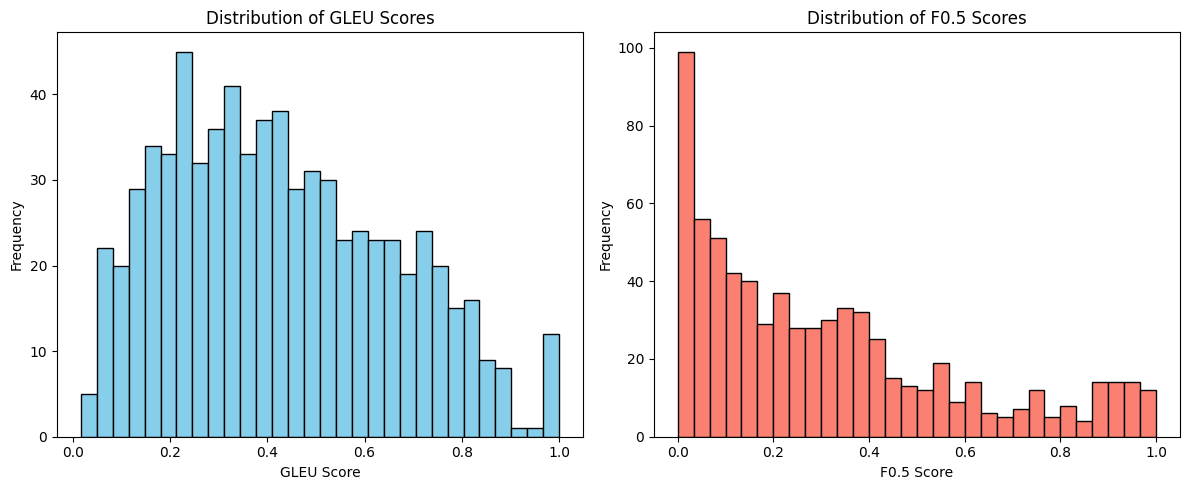

--WI+LOCHNESS--


100%|██████████| 2856/2856 [13:28<00:00,  3.53it/s]


Mean GLEU: 0.759589034936028
Mean F0.5: 0.5807566063106282


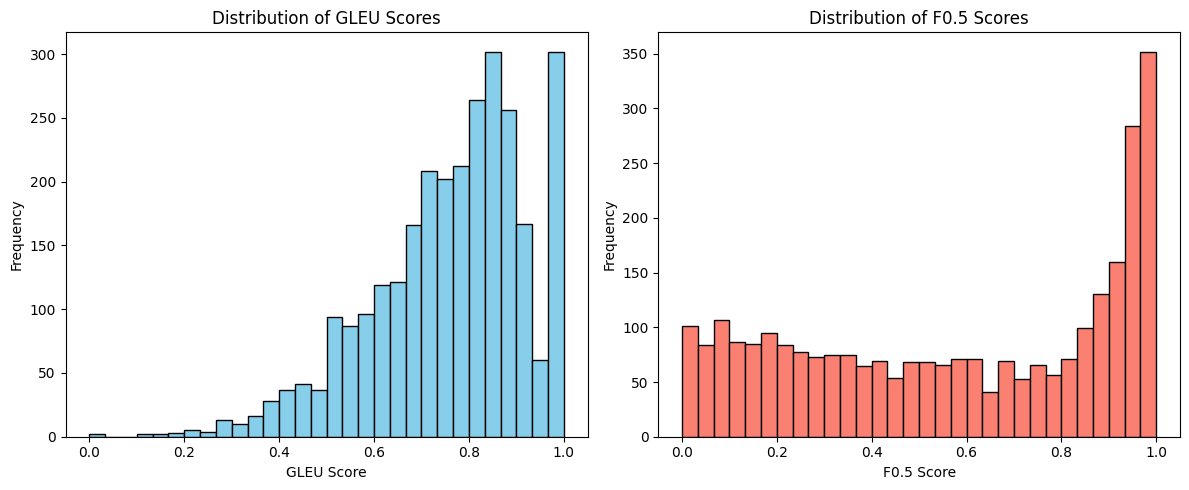

Evaluation result for ./bart_large_no_prefix_61GLEU
--CoNLL--


100%|██████████| 1195/1195 [09:07<00:00,  2.18it/s]

Mean GLEU: 0.6317651281744261
Mean F0.5: 0.4561359531139639


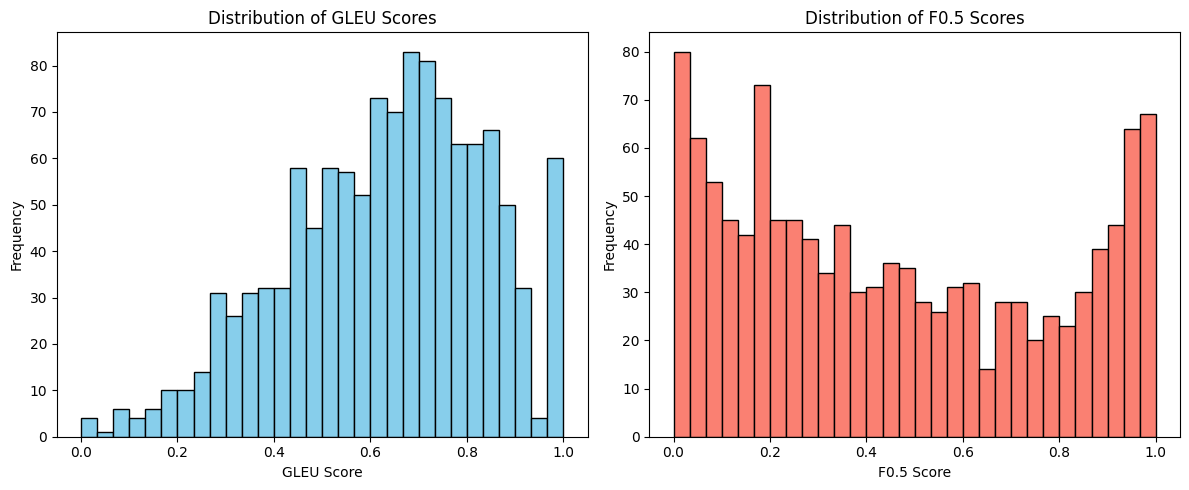

--FCE--


100%|██████████| 1828/1828 [07:12<00:00,  4.23it/s]


Mean GLEU: 0.7380223096079079
Mean F0.5: 0.6261469071112464


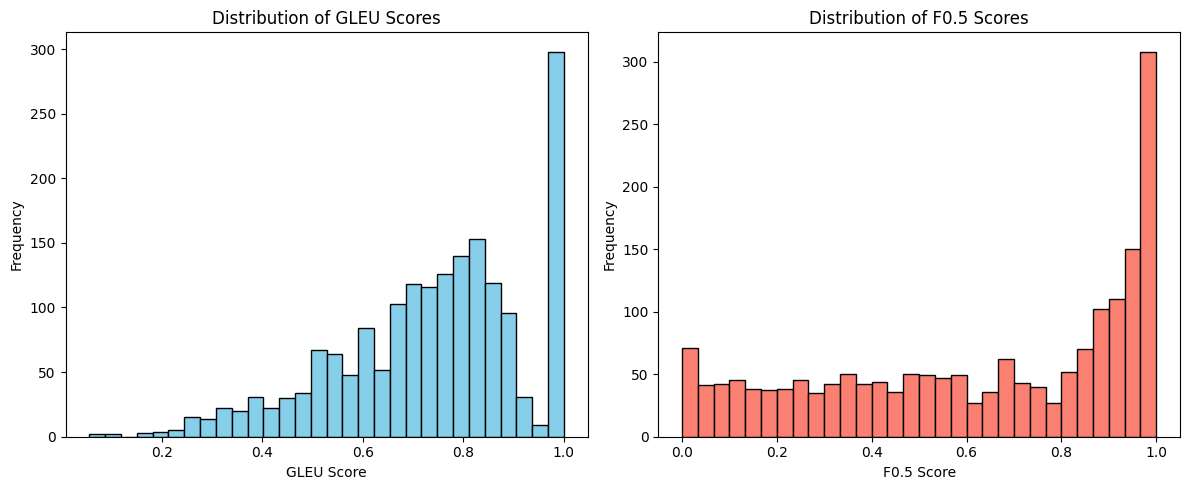

--JFLEG--


100%|██████████| 713/713 [03:29<00:00,  3.40it/s]


Mean GLEU: 0.4438977085168551
Mean F0.5: 0.31344188688100433


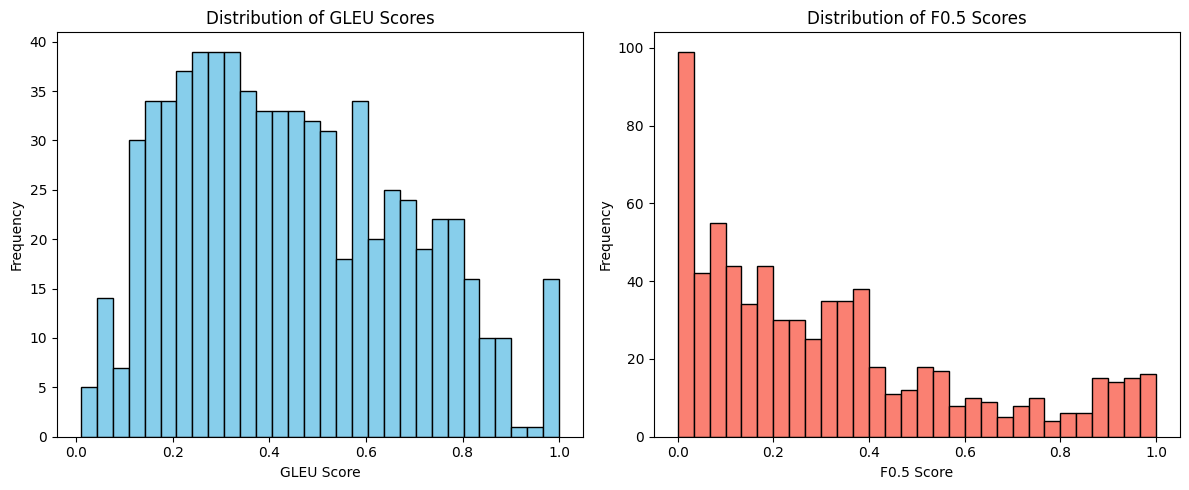

--WI+LOCHNESS--


100%|██████████| 2856/2856 [26:45<00:00,  1.78it/s] 

Mean GLEU: 0.7704700564544994
Mean F0.5: 0.5900092149871409


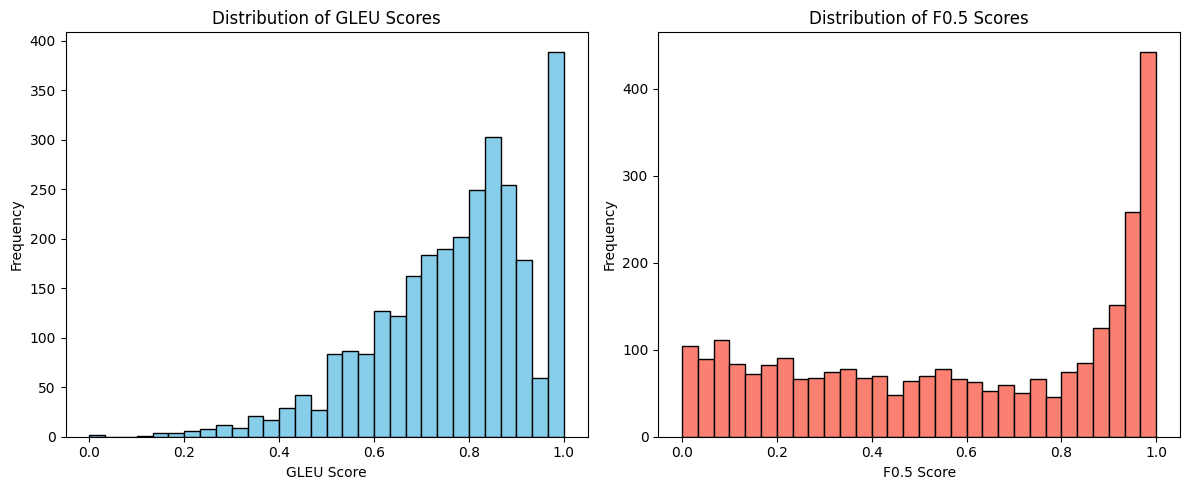

In [8]:
for path in no_prefix_model_paths:
    evaluation_engine = Evaluation(path, False)
    evaluation_engine.evaluate_test()